In [1]:
import math
import random

import matplotlib.pyplot as plt
import pydiffvg
import torch
import skimage
import skimage.io
import ttools.modules

In [2]:
torch.cuda.is_available()

True

In [3]:
pydiffvg.set_use_gpu(torch.cuda.is_available())

In [4]:
pydiffvg.get_device()

device(type='cuda')

In [5]:
fp = '../../data/sandbox/figure_1.jpeg'

In [6]:
target = torch.tensor(skimage.io.imread(fp)).to(torch.float32) / 255.0
target.shape

torch.Size([508, 360, 3])

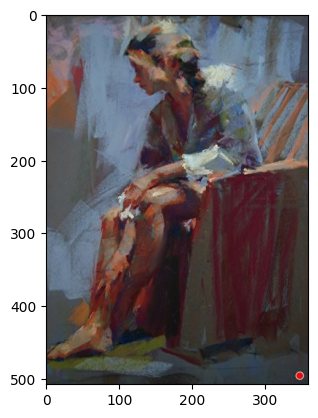

In [7]:
plt.imshow(target)

In [8]:
target = target.to(pydiffvg.get_device())
target = target.unsqueeze(0)
target = target.permute(0, 3, 1, 2) # NHWC -> NCHW
target.shape

torch.Size([1, 3, 508, 360])

In [9]:
canvas_width, canvas_height = target.shape[3], target.shape[2]
num_paths = [100] * 50
max_width = 10.
use_blob = False
num_iter = 201

In [10]:
# layer_to_shapes, layer_to_shape_groups = [], []
# for n in num_paths:
#     shapes = []
#     shape_groups = []
#     for i in range(n):
#         num_segments = random.randint(3, 5)
#         num_control_points = torch.zeros(num_segments, dtype=torch.int32) + 2
#         points = []
#         p0 = (random.random(), random.random())
#         points.append(p0)
#         for j in range(num_segments):
#             radius = 0.05
#             p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
#             p2 = (p1[0] + radius * (random.random() - 0.5), p1[1] + radius * (random.random() - 0.5))
#             p3 = (p2[0] + radius * (random.random() - 0.5), p2[1] + radius * (random.random() - 0.5))
#             points.append(p1)
#             points.append(p2)
#             if j < num_segments - 1:
#                 points.append(p3)
#                 p0 = p3
#         points = torch.tensor(points)
#         points[:, 0] *= canvas_width
#         points[:, 1] *= canvas_height
#         path = pydiffvg.Path(num_control_points = num_control_points,
#                              points = points,
#                              stroke_width = torch.tensor(1.0),
#                              is_closed = True)
#         shapes.append(path)
#         path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
#                                          fill_color = torch.tensor([random.random(),
#                                                                     random.random(),
#                                                                     random.random(),
#                                                                     random.random()]))
#         shape_groups.append(path_group)
#     layer_to_shapes.append(shapes)
#     layer_to_shape_groups.append(shape_groups)

In [11]:
layer_to_shapes, layer_to_shape_groups = [], []
for n in num_paths:
    shapes = []
    shape_groups = []
    for i in range(n):
        num_segments = random.randint(1, 3)
        num_control_points = torch.zeros(num_segments, dtype = torch.int32) + 2
        points = []
        p0 = (random.random(), random.random())
        points.append(p0)
        for j in range(num_segments):
            radius = 0.05
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            p2 = (p1[0] + radius * (random.random() - 0.5), p1[1] + radius * (random.random() - 0.5))
            p3 = (p2[0] + radius * (random.random() - 0.5), p2[1] + radius * (random.random() - 0.5))
            points.append(p1)
            points.append(p2)
            points.append(p3)
            p0 = p3
        points = torch.tensor(points)
        points[:, 0] *= canvas_width
        points[:, 1] *= canvas_height
        #points = torch.rand(3 * num_segments + 1, 2) * min(canvas_width, canvas_height)
        path = pydiffvg.Path(num_control_points = num_control_points,
                             points = points,
                             stroke_width = torch.tensor(1.0),
                             is_closed = False)
        shapes.append(path)
    path_group = pydiffvg.ShapeGroup(
#         shape_ids = torch.tensor([len(shapes) - 1]),
        shape_ids = torch.arange(len(shapes)),
        fill_color = None,
        stroke_color = torch.tensor([random.random(),
                                  random.random(),
                                  random.random(),
                                  random.random()]))
    shape_groups.append(path_group)
    layer_to_shapes.append(shapes)
    layer_to_shape_groups.append(shape_groups)

In [12]:
def render_scene(canvas_width, canvas_height, shapes, shape_groups):
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)

    render = pydiffvg.RenderFunction.apply
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    return img

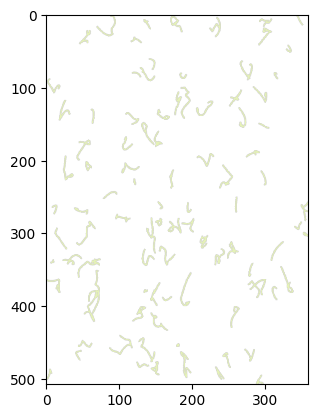

In [13]:
img = render_scene(canvas_width, canvas_height, layer_to_shapes[0], layer_to_shape_groups[0])
plt.imshow(img.cpu().detach())

In [14]:
layer_to_shapes[0][0].points

tensor([[148.2414, 336.2083],
        [139.7043, 326.0943],
        [140.8721, 336.9227],
        [137.6622, 344.9800],
        [131.1860, 342.3633],
        [131.8767, 331.9030],
        [135.6445, 323.6945]])

In [15]:
layer_to_shapes[0][0].stroke_width

tensor(1.)

In [16]:
layer_to_shape_groups[0][0].stroke_color

tensor([0.7834, 0.8944, 0.3825, 0.4580])

In [17]:
points_vars = []
stroke_width_vars = []
color_vars = []
for shapes, shape_groups in zip(layer_to_shapes, layer_to_shape_groups):
    for path in shapes:
        path.points.requires_grad = True
        points_vars.append(path.points)
    if not use_blob:
        for path in shapes:
            path.stroke_width.requires_grad = True
            stroke_width_vars.append(path.stroke_width)
    if use_blob:
        for group in shape_groups:
            group.fill_color.requires_grad = True
            color_vars.append(group.fill_color)
    else:
        for group in shape_groups:
            group.stroke_color.requires_grad = True
            color_vars.append(group.stroke_color)

In [18]:
imgs = torch.zeros(len(layer_to_shapes), canvas_height, canvas_width, 3, dtype=torch.float32)
for i, (shapes, shape_groups) in enumerate(zip(layer_to_shapes, layer_to_shape_groups)):
    img = render_scene(canvas_width, canvas_height, shapes, shape_groups)
    # Compose img with white background
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
    imgs[i] = img

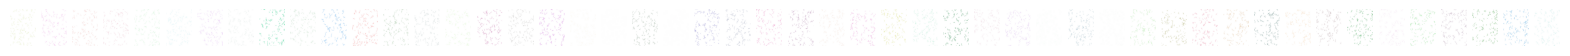

In [19]:
fig, axs = plt.subplots(ncols=imgs.shape[0], figsize=(20, 4))
for img, ax in zip(imgs, axs):
    ax.imshow(img.cpu().detach())
    ax.axis('off')

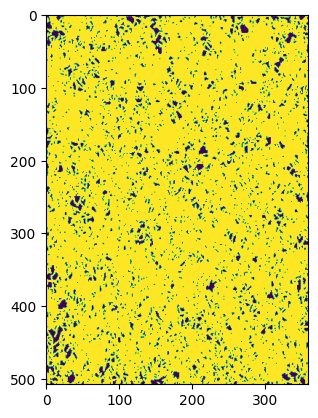

In [20]:
mask = imgs.sum(dim=(0, -1))!=imgs.shape[0] * 3
plt.imshow(mask.cpu().detach())

In [21]:
def merge_imgs(x1, x2):
    x1, x2 = 1 - x1, 1 - x2 # easier operations with flipped intensity
    m1, m2 = x1.sum(dim=-1)!=0, x2.sum(dim=-1)!=0
    both = m1 & m2
    
    img_both = x1 + x2
    merged = (x1 + x2) / 2
    img_both[both] = merged[both]
    
    return 1 - img_both

def merge_img_stack(imgs):
    img = None
    for i in range(imgs.shape[0]):
        if img is None:
            img = imgs[i]
        else:
            img = merge_imgs(img, imgs[i])
    return img

In [22]:
# Optimizers
points_optim = torch.optim.Adam(points_vars, lr=1.0)
if len(stroke_width_vars) > 0:
    width_optim = torch.optim.Adam(stroke_width_vars, lr=0.1)
color_optim = torch.optim.Adam(color_vars, lr=0.01)

iteration: 0


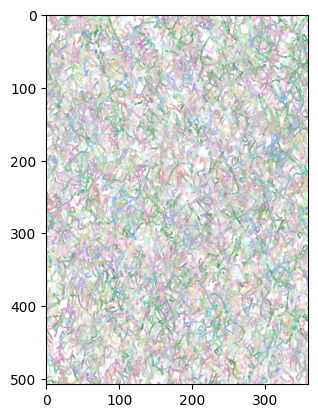

render loss: 0.2879220247268677
iteration: 1
render loss: 0.2649043798446655
iteration: 2
render loss: 0.24814631044864655
iteration: 3
render loss: 0.23303239047527313
iteration: 4
render loss: 0.21934783458709717
iteration: 5
render loss: 0.20672516524791718
iteration: 6
render loss: 0.19475014507770538
iteration: 7
render loss: 0.18330933153629303
iteration: 8
render loss: 0.17244867980480194
iteration: 9
render loss: 0.16202479600906372
iteration: 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


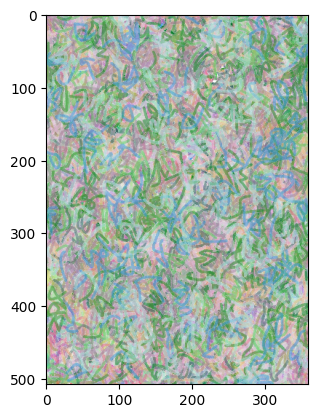

render loss: 0.15223319828510284
iteration: 11
render loss: 0.142886683344841
iteration: 12
render loss: 0.1338358074426651
iteration: 13
render loss: 0.12560541927814484
iteration: 14
render loss: 0.11767765134572983
iteration: 15
render loss: 0.11044692993164062
iteration: 16
render loss: 0.10364086180925369
iteration: 17
render loss: 0.09730159491300583
iteration: 18
render loss: 0.09151973575353622
iteration: 19
render loss: 0.08625667542219162
iteration: 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


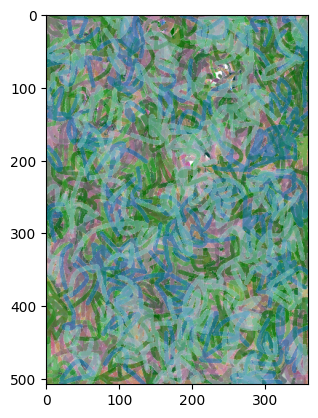

render loss: 0.08146315068006516
iteration: 21
render loss: 0.07698222994804382
iteration: 22
render loss: 0.07307161390781403
iteration: 23
render loss: 0.06955302506685257
iteration: 24
render loss: 0.06631054729223251
iteration: 25
render loss: 0.06343938410282135
iteration: 26
render loss: 0.060721661895513535
iteration: 27
render loss: 0.058215320110321045
iteration: 28
render loss: 0.05588114261627197
iteration: 29
render loss: 0.05385110154747963
iteration: 30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


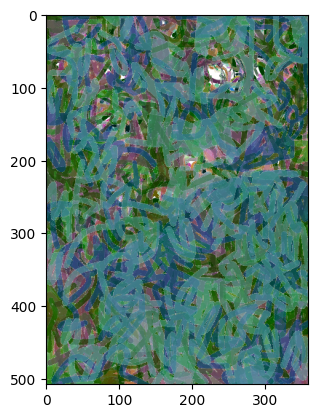

render loss: 0.05190062150359154
iteration: 31
render loss: 0.05001845955848694
iteration: 32
render loss: 0.0482189916074276
iteration: 33
render loss: 0.0465073324739933
iteration: 34
render loss: 0.0448780320584774
iteration: 35
render loss: 0.043359026312828064
iteration: 36
render loss: 0.04187694564461708
iteration: 37
render loss: 0.04044157639145851
iteration: 38
render loss: 0.03892035782337189
iteration: 39
render loss: 0.03749900683760643
iteration: 40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


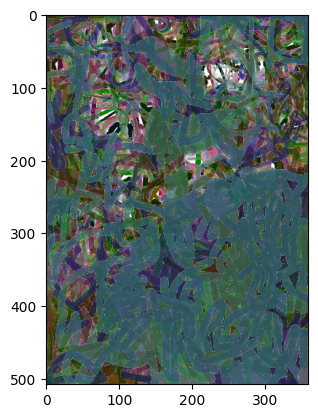

render loss: 0.036188509315252304
iteration: 41
render loss: 0.03480354696512222
iteration: 42
render loss: 0.03347974270582199
iteration: 43
render loss: 0.03212251886725426
iteration: 44
render loss: 0.030970126390457153
iteration: 45
render loss: 0.02992335334420204
iteration: 46
render loss: 0.02881776914000511
iteration: 47
render loss: 0.027726413682103157
iteration: 48
render loss: 0.026642674580216408
iteration: 49
render loss: 0.02568480372428894
iteration: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


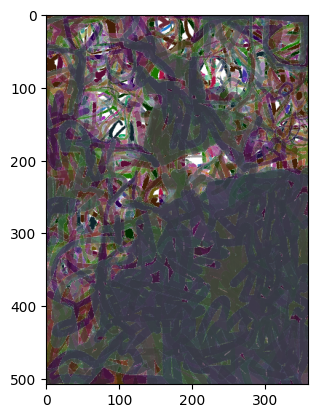

render loss: 0.024664301425218582
iteration: 51
render loss: 0.023771554231643677
iteration: 52
render loss: 0.022976521402597427
iteration: 53
render loss: 0.022160565480589867
iteration: 54
render loss: 0.021324507892131805
iteration: 55
render loss: 0.02060825377702713
iteration: 56
render loss: 0.01996697299182415
iteration: 57
render loss: 0.01941797137260437
iteration: 58
render loss: 0.018908081576228142
iteration: 59
render loss: 0.018560929223895073
iteration: 60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


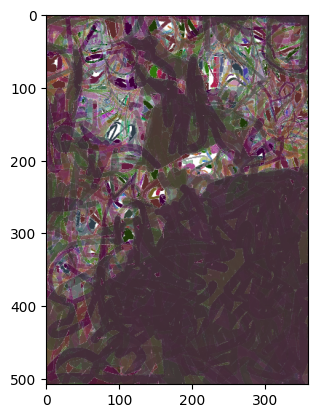

render loss: 0.0181275587528944
iteration: 61
render loss: 0.01775348372757435
iteration: 62
render loss: 0.01737232506275177
iteration: 63
render loss: 0.016992224380373955
iteration: 64
render loss: 0.01669025607407093
iteration: 65
render loss: 0.0162701103836298
iteration: 66
render loss: 0.01592695713043213
iteration: 67
render loss: 0.015647638589143753
iteration: 68
render loss: 0.01532079093158245
iteration: 69
render loss: 0.015051578171551228
iteration: 70


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


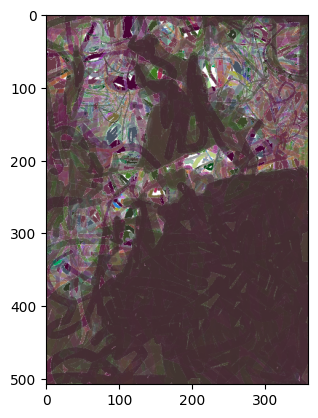

render loss: 0.014816436916589737
iteration: 71
render loss: 0.01459808461368084
iteration: 72
render loss: 0.014408601447939873
iteration: 73
render loss: 0.014255071990191936
iteration: 74
render loss: 0.014119292609393597
iteration: 75
render loss: 0.01398393139243126
iteration: 76
render loss: 0.013910154812037945
iteration: 77
render loss: 0.013764314353466034
iteration: 78
render loss: 0.013689223676919937
iteration: 79
render loss: 0.013607694767415524
iteration: 80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


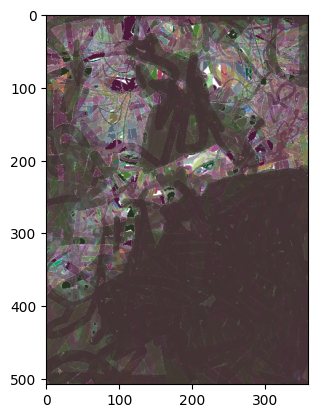

render loss: 0.013545377179980278
iteration: 81
render loss: 0.013480639085173607
iteration: 82
render loss: 0.013483623042702675
iteration: 83
render loss: 0.013469120487570763
iteration: 84
render loss: 0.013423997908830643
iteration: 85
render loss: 0.013428105972707272
iteration: 86
render loss: 0.013394692912697792
iteration: 87
render loss: 0.013381396420300007
iteration: 88
render loss: 0.013442420400679111
iteration: 89
render loss: 0.013514403253793716
iteration: 90


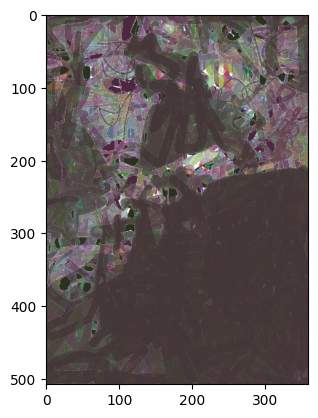

render loss: 0.013559820130467415
iteration: 91
render loss: 0.013621451333165169
iteration: 92
render loss: 0.013697287999093533
iteration: 93
render loss: 0.013798976317048073
iteration: 94
render loss: 0.013913086615502834
iteration: 95
render loss: 0.014021730050444603
iteration: 96
render loss: 0.014115150086581707
iteration: 97
render loss: 0.014135060831904411
iteration: 98
render loss: 0.014201054349541664
iteration: 99
render loss: 0.014238176867365837
iteration: 100


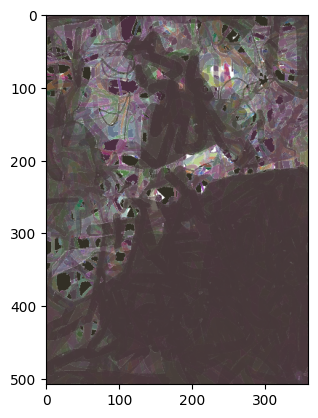

render loss: 0.014304994605481625
iteration: 101
render loss: 0.014326521195471287
iteration: 102
render loss: 0.014372555539011955
iteration: 103
render loss: 0.014408367685973644
iteration: 104
render loss: 0.014421239495277405
iteration: 105
render loss: 0.01444584596902132
iteration: 106
render loss: 0.014505937695503235
iteration: 107
render loss: 0.014501970261335373
iteration: 108
render loss: 0.014536469243466854
iteration: 109
render loss: 0.014574125409126282
iteration: 110


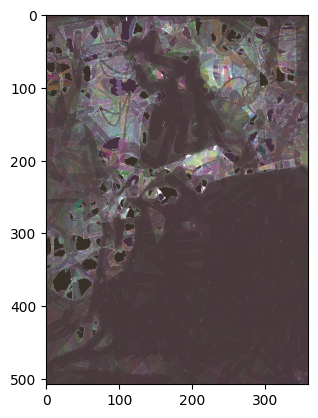

render loss: 0.014591215178370476
iteration: 111
render loss: 0.014633598737418652
iteration: 112
render loss: 0.014679038897156715
iteration: 113
render loss: 0.014724019914865494
iteration: 114
render loss: 0.014784821309149265
iteration: 115
render loss: 0.014858821406960487
iteration: 116
render loss: 0.014864022843539715
iteration: 117
render loss: 0.014902160502970219
iteration: 118
render loss: 0.014980416744947433
iteration: 119
render loss: 0.015050027519464493
iteration: 120


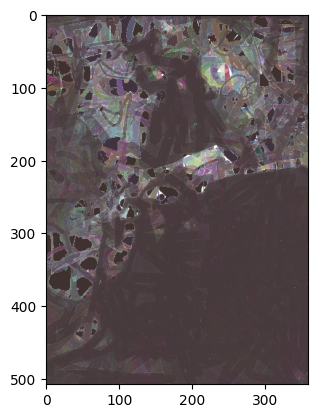

render loss: 0.015065018087625504
iteration: 121
render loss: 0.01503757108002901
iteration: 122
render loss: 0.015044614672660828
iteration: 123
render loss: 0.01508613582700491
iteration: 124
render loss: 0.015092262998223305
iteration: 125
render loss: 0.015102825127542019
iteration: 126
render loss: 0.015129533596336842
iteration: 127
render loss: 0.015128257684409618
iteration: 128
render loss: 0.015123292803764343
iteration: 129
render loss: 0.015139036811888218
iteration: 130


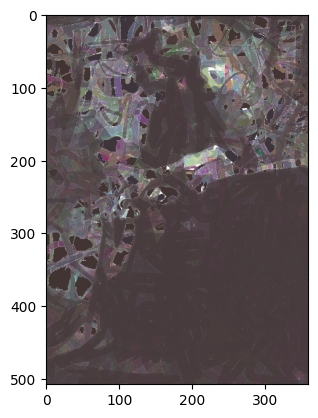

render loss: 0.015065453015267849
iteration: 131
render loss: 0.015023336745798588
iteration: 132
render loss: 0.014991316944360733
iteration: 133
render loss: 0.014994357712566853
iteration: 134
render loss: 0.015028899535536766
iteration: 135
render loss: 0.015011131763458252
iteration: 136
render loss: 0.015006806701421738
iteration: 137
render loss: 0.014999163337051868
iteration: 138
render loss: 0.014993894845247269
iteration: 139
render loss: 0.01497776247560978
iteration: 140


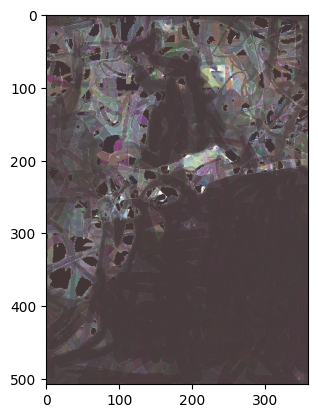

render loss: 0.014933827333152294
iteration: 141
render loss: 0.014946031384170055
iteration: 142
render loss: 0.014914998784661293
iteration: 143
render loss: 0.014889270067214966
iteration: 144
render loss: 0.01486291829496622
iteration: 145
render loss: 0.01486875955015421
iteration: 146
render loss: 0.014817031100392342
iteration: 147
render loss: 0.014790723100304604
iteration: 148
render loss: 0.01474730670452118
iteration: 149
render loss: 0.014756993390619755
iteration: 150


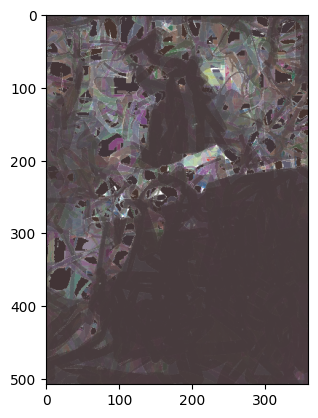

render loss: 0.01473191101104021
iteration: 151
render loss: 0.014669574797153473
iteration: 152
render loss: 0.014598004519939423
iteration: 153
render loss: 0.014521339908242226
iteration: 154
render loss: 0.014489235356450081
iteration: 155
render loss: 0.014430701732635498
iteration: 156
render loss: 0.014351455494761467
iteration: 157
render loss: 0.01432129554450512
iteration: 158
render loss: 0.014288369566202164
iteration: 159
render loss: 0.014268801547586918
iteration: 160


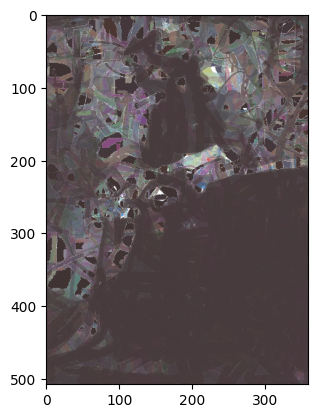

render loss: 0.01426759734749794
iteration: 161
render loss: 0.014254830777645111
iteration: 162
render loss: 0.014260116033256054
iteration: 163
render loss: 0.014220944605767727
iteration: 164
render loss: 0.014216005802154541
iteration: 165
render loss: 0.014181527309119701
iteration: 166
render loss: 0.014124387875199318
iteration: 167
render loss: 0.014077315106987953
iteration: 168
render loss: 0.014044656418263912
iteration: 169
render loss: 0.014017405919730663
iteration: 170


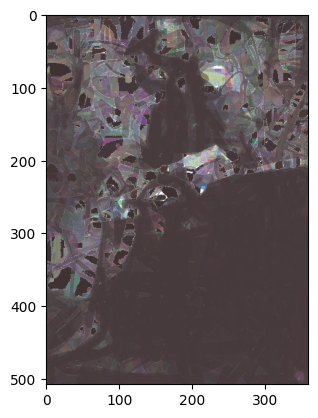

render loss: 0.014014674350619316
iteration: 171
render loss: 0.01393512636423111
iteration: 172
render loss: 0.013883753679692745
iteration: 173
render loss: 0.01382763683795929
iteration: 174
render loss: 0.013778786174952984
iteration: 175
render loss: 0.013760278932750225
iteration: 176
render loss: 0.013731793500483036
iteration: 177
render loss: 0.013661201111972332
iteration: 178
render loss: 0.013630191795527935
iteration: 179
render loss: 0.01358759868890047
iteration: 180


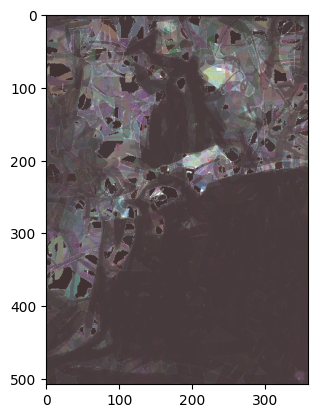

render loss: 0.013576109893620014
iteration: 181
render loss: 0.013581992127001286
iteration: 182
render loss: 0.01356434915214777
iteration: 183
render loss: 0.01354996208101511
iteration: 184
render loss: 0.013525428250432014
iteration: 185
render loss: 0.013506840914487839
iteration: 186
render loss: 0.013482563197612762
iteration: 187
render loss: 0.013442063704133034
iteration: 188
render loss: 0.01342736091464758
iteration: 189
render loss: 0.013430268503725529
iteration: 190


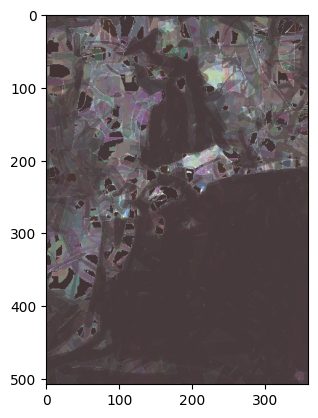

render loss: 0.013438169844448566
iteration: 191
render loss: 0.013394397683441639
iteration: 192
render loss: 0.013400903902947903
iteration: 193
render loss: 0.013361211866140366
iteration: 194
render loss: 0.01331532746553421
iteration: 195
render loss: 0.013275235891342163
iteration: 196
render loss: 0.013216476887464523
iteration: 197
render loss: 0.01318750437349081
iteration: 198
render loss: 0.013140378519892693
iteration: 199
render loss: 0.013067898340523243
iteration: 200


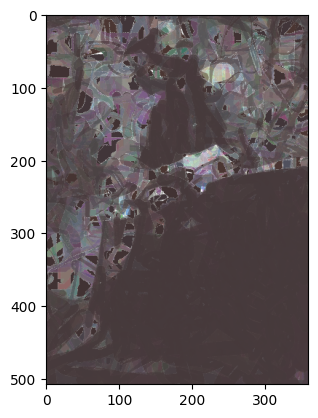

render loss: 0.01300748996436596


In [23]:
# Adam iterations.
for t in range(num_iter):
    print('iteration:', t)
    
    # zero grads
    points_optim.zero_grad()
    if len(stroke_width_vars) > 0:
        width_optim.zero_grad()
    color_optim.zero_grad()
    
    # Forward pass: render the image.
    imgs = torch.zeros(len(layer_to_shapes), canvas_height, canvas_width, 3, dtype=torch.float32, device=pydiffvg.get_device())
    for i, (shapes, shape_groups) in enumerate(zip(layer_to_shapes, layer_to_shape_groups)):
        img = render_scene(canvas_width, canvas_height, shapes, shape_groups)
        # Compose img with white background
        img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(
            img.shape[0], img.shape[1], 3, device=pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        imgs[i] = img
    img = merge_img_stack(imgs)
    
    if t % 10 == 0:
        plt.imshow(img.cpu().detach())
        plt.show()
    
    # Convert img from HWC to NCHW
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
#     if args.use_lpips_loss:
#         loss = perception_loss(img, target) + (img.mean() - target.mean()).pow(2)
#     else:
    loss = (img - target).pow(2).mean()
    print('render loss:', loss.item())

    # Backpropagate the gradients.
    loss.backward()

    # Take a gradient descent step.
    points_optim.step()
    if len(stroke_width_vars) > 0:
        width_optim.step()
    color_optim.step()

    if len(stroke_width_vars) > 0:
        for path in shapes:
            path.stroke_width.data.clamp_(1.0, max_width)
            path.stroke_width.data.clamp_(.1, max_width)
    if use_blob:
        for group in shape_groups:
            group.fill_color.data.clamp_(0.0, 1.0)
    else:
        for group in shape_groups:
            group.stroke_color.data.clamp_(0.0, 1.0)

#     if t % 10 == 0 or t == args.num_iter - 1:
#         pydiffvg.save_svg('results/painterly_rendering/iter_{}.svg'.format(t),
#                           canvas_width, canvas_height, shapes, shape_groups)

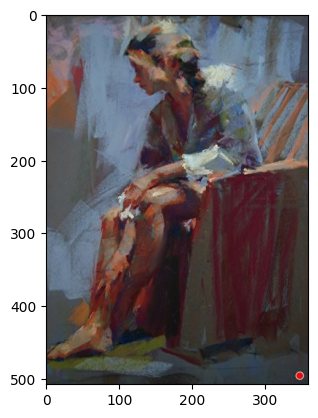

In [24]:
plt.imshow(target[0].cpu().detach().permute(1, 2, 0))

In [26]:
target[0].cpu().detach().shape

torch.Size([3, 508, 360])

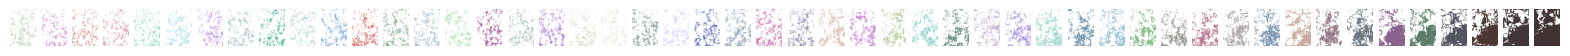

In [25]:
fig, axs = plt.subplots(ncols=imgs.shape[0], figsize=(20, 4))
for img, ax in zip(imgs, axs):
    ax.imshow(img.cpu().detach())
    ax.axis('off')